In [7]:
### import libraries, input parameters, initilize dictionaries and arrays 
import pysam
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt

### start of input
# quality score 30 corresponds to 1/1000 error rate, or 1e-3 sequencing error 
minimum_qaulity_score=30
P=1e-3 #  propability of sequencing error given qaulity score of 30
max_mapping_score=42 # the maximal mapping quality means unique alignment, with bowtie2 this number is 42
p_cutoff=0.05 # the cutoff for significance, note that bonferroni correction is used below
bam_file_to_read="aligned_RNAreads_gills_sorted.bam"
output_file="editing_sites_spectrin_gills.txt"
total_orf_size=16607506
length_of_read=150
### end of input

# initilize dictionary for counts per letter
counts_per_letter={}
# initilize dictionary for type of modification
number_of_modifications={}
type_of_modifications=['AC','AG','AT','CA','CG','CT','GA','GC','GT','TA','TC','TG']
for x in type_of_modifications:
    number_of_modifications[x]=0
# initilize numpy array for position of mismatch in the read
position_of_mismatch_inside_the_read=np.zeros(length_of_read) # note that for the gills the length of read is 150
# initilize numpy array for position of match in the read
position_of_match_inside_the_read=np.zeros(length_of_read) # note that for the gills the length of read is 150

In [8]:
### use pysam to examine all the reads aligned for each position of each transcipt and detect editing sites
samfile = pysam.AlignmentFile(bam_file_to_read,"rb") # read the indexed and sorted bam file using pysam 
file2 = open(output_file,"w") # file in which the detected editing sited will be listed 
transcript_name='comp141540_c0_seq3' # in case only one transcript is run ('comp141540_c0_seq3' is spectrin)

# run over all transcripts
file2.write("\nname of transcript = %s\n" % transcript_name) # list the current transcript
# run over all positions of the transcript and fetch the reads aligned to it 
# only fetch reads that have the maximal mapping score (i.e. unique alignment)
for pileupcolumn in samfile.pileup(transcript_name,min_mapping_quality=max_mapping_score): 
    position=pileupcolumn.pos
    # initilize the dictionary counts_per_letter
    type_of_letters=['A','C','G','T']
    for x in type_of_letters:
        counts_per_letter[x]=0
    # run over all reads that align against the transcript in the given position
    for pileupread in pileupcolumn.pileups:
        # query position is None if is_del or is_refskip is set
        if not pileupread.is_del and not pileupread.is_refskip:
            # demand minimum quality score for the aligned base
            if pileupread.alignment.query_qualities[pileupread.query_position]>=minimum_qaulity_score:
                # detect the base
                letter=pileupread.alignment.query_sequence[pileupread.query_position]
                # count how many times each base was detected
                counts_per_letter[letter]=counts_per_letter[letter]+1 
    # sort the counts per base to detect the base most frequent and the second base i.e. the modification
    sorted_dict = dict( sorted(counts_per_letter.items(),
                               key=lambda item: item[1],
                               reverse=True)) # sort descending
    i=0 # a running number to detect the first and second most frequent bases
    N=0 # total number of reads aligned to the first and second most frequent bases 
    for key, value in sorted_dict.items():
        i=i+1 
        if i==1:
            N=N+value
            first_letter=key # the most frequent base
        elif i==2:
            X=value # the number of times the modified base appeared
            N=N+value
            second_letter=key # the second most frequent base
            modification=first_letter+second_letter # the modification, for example AG (i.e A changed to G)
        else:
            break
    # given a rate of sequencing error P, total number of counts N, and modified counts X \
    #  the probability of event being a sequencing error is 1 - binomial_CDF(X-1,N,P) \
    #  this is the same as binomial_CDF(N-X,N,1-P) (but the latter is more accurate due to rounding errors) 
    prob = binom.cdf(N-X,N,1-P)  
    # bonferroni correction p_cutoff divided by the overall number of tests
    if prob<(p_cutoff/total_orf_size):
        # print the total number of reads aligned for the specfic location inside the transcript
        file2.write("\ncoverage at base %s = %s" % (pileupcolumn.pos, pileupcolumn.n))  
        # sort the number of bases and print them to file
        for key, value in sorted_dict.items():
            file2.write('\ncounts of base %s = %s' % (key,str(value)))
        file2.write('\nX is %s and N is %s' % (str(X),str(N))) # print X and N, as defined above
        part1='\nP-value for sequencing error is\t' 
        part2="{:.2e}".format(prob)
        part3='\n'
        file2.write(part1+part2+part3) # print the P-value
        # update the number of modifications
        number_of_modifications[modification]=number_of_modifications[modification]+1
        # check the location of the match and mismatch in the read 
        #  to estimate if the modifications came from the reads ends 
        # run over all reads that align against the transcript in the given position 
        for pileupread in pileupcolumn.pileups:
            # query position is None if is_del or is_refskip is set
            if not pileupread.is_del and not pileupread.is_refskip:
                # demand minimum quality score for the aligned base
                if pileupread.alignment.query_qualities[pileupread.query_position]>=minimum_qaulity_score:
                    # detect the base
                    letter=pileupread.alignment.query_sequence[pileupread.query_position]
                    if (letter==first_letter): # these are reads that show the match
                        position_of_match_inside_the_read[pileupread.query_position]=\
                        position_of_match_inside_the_read[pileupread.query_position]+1
                    elif (letter==second_letter): # these are reads that show the mismatch
                        position_of_mismatch_inside_the_read[pileupread.query_position]=\
                        position_of_mismatch_inside_the_read[pileupread.query_position]+1
file2.close()

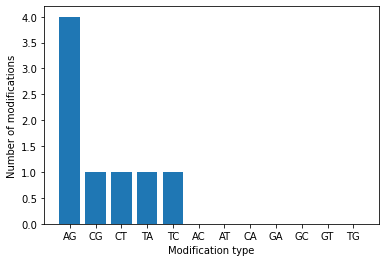

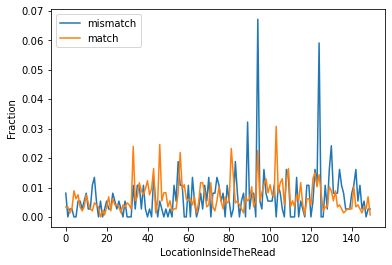

In [9]:
### plot the results
# plot the number of modifications per modification type sorted from highest to lowest 
sorted_dict = dict( sorted(number_of_modifications.items(),
                        key=lambda item: item[1],
                        reverse=True)) # sort descending
plt.bar(range(len(sorted_dict)), list(sorted_dict.values()), align='center')
plt.xticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.ylabel('Number of modifications')
plt.xlabel('Modification type')
plt.show()
# plot the number of mismatches per position inside the read from base 1 to end
plt.plot(list(range(0, length_of_read)),\
         position_of_mismatch_inside_the_read/sum(position_of_mismatch_inside_the_read),\
         label = "mismatch")
# on the same figure, plot the number of matches per position inside the read from base 1 to end
plt.plot(list(range(0, length_of_read)),\
         position_of_match_inside_the_read/sum(position_of_match_inside_the_read),\
         label = "match")
plt.ylabel('Fraction')
plt.xlabel('LocationInsideTheRead')
plt.legend()
plt.show()
samfile.close()